<span style='font-family: Times; font-size: 2em;'>MIMIC v. 2.2 Database Stratified Hospitalization & mortality </span>


**Veronica Ramirez-Lopera** 

### Objectives: 
#### Main objective:
To assess whether the MIMIC-IV database contains sufficient sequential ECGs to support a study 
on the dynamic aging of the heart in heart failure patients.

#### Secondary objectives:
1. To analyze the timing of ECGs during each hospitalization.
1. To visualize patient distribution by ECG frequency and hospitalization count.
1. To describe a plan for the research protocol modifications according to the ECG data.

### **Table of contents**
- [Introduction](#introduction)
- [Package Requirements](#package_requirements)
- [Data importing](#importing)
- [Data filtering and visualization](#filtering)
- [Conclusions and plan](#conclusions)
- [References](#references)

## Introduction <a name='introduction'></a>
MIMIC-IV is a freely available electronic health record (EHR) dataset encompassing a decade of patient information (2008-2019) from Beth Israel Deaconess Medical Center [1]. It surpasses its predecessor, MIMIC-III, with a better structure and additional patient information [2, 3].

The dataset draws upon two primary sources: a comprehensive hospital-wide EHR system and an ICU-specific clinical information system [1]. Rigorous de-identification procedures ensure patient privacy while preserving the data's scientific integrity.

It includes vital signs, diagnoses, medications, procedures, and de-identified clinical notes [1]. Researchers leverage MIMIC-IV to investigate disease progression, train machine learning models, and develop clinical decision support tools [1, 2].

As a result, null dates of death indicate the patient was alive at least up to that time point. Inferences regarding patient death beyond one year cannot be made using MIMIC-IV (as per the PhyioNet website) [2]. The majority of patient death information is acquired from hospital records when the individual dies within the BIDMC or an affiliated institute.

MIMIC-IV also offers a dedicated module: MIMIC-IV ECG. This subset focuses specifically on diagnostic electrocardiograms (ECGs) [2]. It includes approximately 800,000 10-second ECG recordings from nearly 160,000 unique patients. Each ECG utilizes 12 leads and is sampled at 500 Hz [3].


## Package requirements <a name='package_requirements'></a>

Notes: 

1- You need to install gcloud if you haven't already. Alternatively, you can use the provided csv files that contain the data.


In [1]:


from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro
import wfdb
import scipy.signal as signal
import torch
import os
import tqdm
import h5py
import torch
import os
import json
import numpy as np
import argparse
from warnings import warn
import pandas as pd
from lifelines import CoxPHFitter
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time 
from scipy.stats import mannwhitneyu


# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 

In [2]:
# Import csv for the mortality data

# Save the mortality data to a CSV file

path_mort = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\mortality_stratified.csv'
mortality = pd.read_csv(path_mort)

# Import the hospitalization data 

path_hosp = r'C:\Users\Vero Ramirez\Desktop\CODE\\CODE\hospitalization_stratified.csv'
hospitalization = pd.read_csv(path_hosp)

In [3]:
mortality.head(), hospitalization.head()


(   Unnamed: 0  subject_id_x   hadm_id            admittime  \
 0           0      10000980  20897796  2193-08-15 01:01:00   
 1           1      10001843  21728396  2131-11-09 16:05:00   
 2           2      10001877  21320596  2150-11-21 23:02:00   
 3           3      10002013  21763296  2165-11-23 08:19:00   
 4           4      10002131  24065018  2128-03-17 14:53:00   
 
              dischtime     admission_type      admission_location  \
 0  2193-08-17 15:07:00  OBSERVATION ADMIT   WALK-IN/SELF REFERRAL   
 1  2131-11-11 11:23:00  OBSERVATION ADMIT  TRANSFER FROM HOSPITAL   
 2  2150-11-23 16:46:00     EU OBSERVATION          EMERGENCY ROOM   
 3  2165-11-26 15:40:00       DIRECT EMER.         CLINIC REFERRAL   
 4  2128-03-19 16:25:00           EW EMER.          EMERGENCY ROOM   
 
                      race gender anchor_year_group  anchor_year  anchor_age  \
 0  BLACK/AFRICAN AMERICAN      F       2008 - 2010         2186          73   
 1                   WHITE      M     

LEts start with GENDER, first mortality then hospitalization count

In [4]:
# Lets group the data by gender

mortality_f = mortality[mortality['gender'] == 'F']
mortality_m = mortality[mortality['gender'] == 'M']

hosp_f = hospitalization[hospitalization['gender'] == 'F']
hosp_m = hospitalization[hospitalization['gender'] == 'M']

In [5]:
mortality_f.head()

,Unnamed: 0,subject_id_x,hadm_id,admittime,dischtime,admission_type,admission_location,race,gender,anchor_year_group,anchor_year,anchor_age,dod,study_id,file_name,ecg_time,path,length_of_stay_(days),subject_id_y,icd_code,icd_version,seq_num,long_title,age,predicted_age,heart_age_gap,heart_age_category,time_to_event,event_indicator,Advanced,Decelerated
0,0,10000980,20897796,2193-08-15 01:01:00,2193-08-17 15:07:00,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,BLACK/AFRICAN AMERICAN,F,2008 - 2010,2186,73,2193-08-26,48132909.0,48132909.0,2193-08-15 10:45:00,files/p1000/p10000980/s48132909/48132909,2,10000980.0,I5033,10.0,2.0,Acute on chronic diastolic (congestive) heart ...,80,57.418945,-22.581055,Decelerated,10.0,1,0,1
3,3,10002013,21763296,2165-11-23 08:19:00,2165-11-26 15:40:00,DIRECT EMER.,CLINIC REFERRAL,WHITE,F,2008 - 2010,2156,53,NaN,47158381.0,47158381.0,2165-11-23 10:23:00,files/p1000/p10002013/s47158381/47158381,3,10002013.0,I5032,10.0,6.0,Chronic diastolic (congestive) heart failure,62,54.038101,-7.961899,Normal,400.0,0,0,0
4,4,10002131,24065018,2128-03-17 14:53:00,2128-03-19 16:25:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2011 - 2013,2123,87,2128-03-21,49320902.0,49320902.0,2128-03-17 16:56:00,files/p1000/p10002131/s49320902/49320902,2,10002131.0,I5033,10.0,2.0,Acute on chronic diastolic (congestive) heart ...,92,80.295738,-11.704262,Decelerated,3.0,1,0,1
5,5,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,EW EMER.,PROCEDURE SITE,WHITE,F,2008 - 2010,2128,80,2131-03-10,42804166.0,42804166.0,2129-08-04 13:06:00,files/p1000/p10002155/s42804166/42804166,14,10002155.0,4280,9.0,17.0,"Congestive heart failure, unspecified",81,55.879486,-25.120514,Decelerated,582.0,0,0,1
6,6,10002428,23473524,2156-05-11 14:49:00,2156-05-22 14:16:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2011 - 2013,2155,80,NaN,47914204.0,47914204.0,2156-05-11 17:59:00,files/p1000/p10002428/s47914204/47914204,10,10002428.0,4280,9.0,7.0,"Congestive heart failure, unspecified",81,61.577408,-19.422592,Decelerated,400.0,0,0,1


C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\3529294734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mortality, x='gender', palette='pastel')


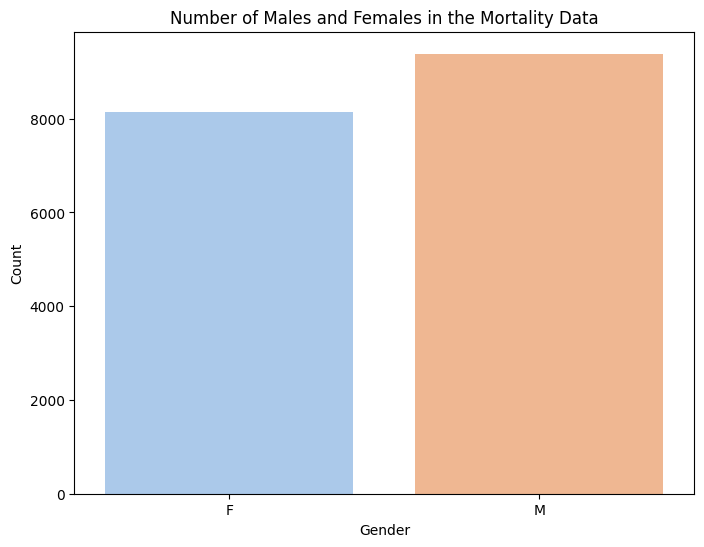

In [6]:


# Create a count plot for gender in the mortality DataFrame
plt.figure(figsize=(8, 6))
sns.countplot(data=mortality, x='gender', palette='pastel')

# Set the title and labels
plt.title('Number of Males and Females in the Mortality Data')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()


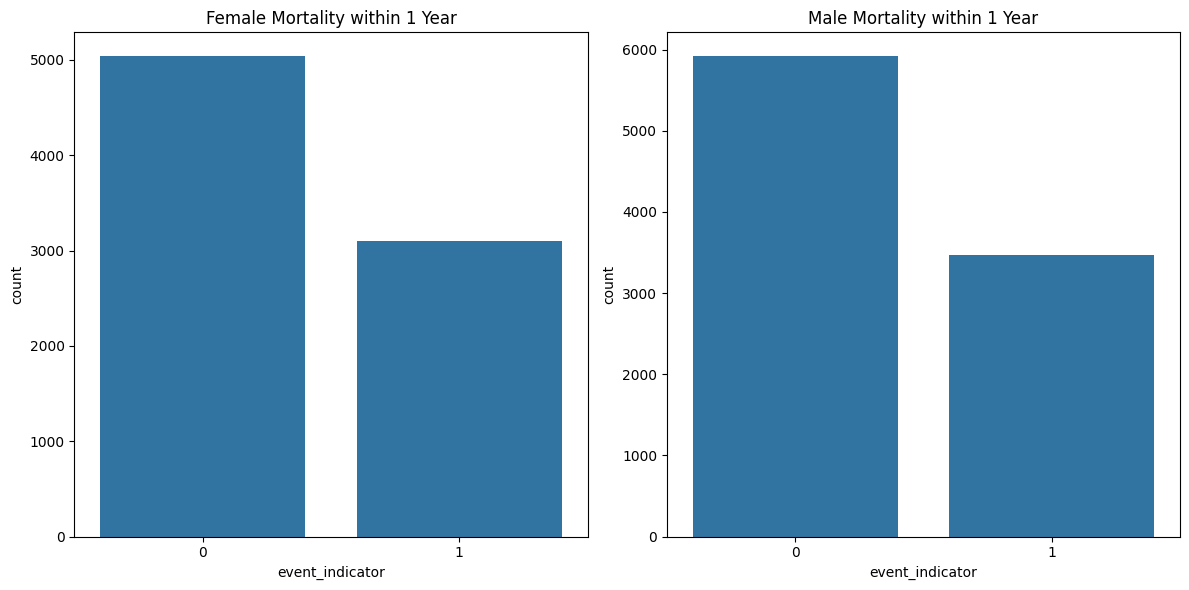

In [7]:
# Lets plot the mortality data

'''
barplot for males and females that passed away within 1 year of their last hospitalization 
(event_indicator = 1) and those that did not (event = 0)

'''

# Aggregate the data by 'event_indicator' to count occurrences for females and males
mortality_f_counts = mortality_f.groupby('event_indicator').size().reset_index(name='count')
mortality_m_counts = mortality_m.groupby('event_indicator').size().reset_index(name='count')

# Create a 1x2 subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Barplot for females
sns.barplot(x='event_indicator', y='count', data=mortality_f_counts, ax=ax[0])
ax[0].set_title('Female Mortality within 1 Year')

# Barplot for males
sns.barplot(x='event_indicator', y='count', data=mortality_m_counts, ax=ax[1])
ax[1].set_title('Male Mortality within 1 Year')

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
correlation = mortality_f[['heart_age_gap', 'event_indicator']].corr(method='spearman')
print( f'The Spearman correlation coefficient between the heart age gap and the event indicator \
      is: {correlation["event_indicator"]["heart_age_gap"]}')

correlation = mortality_m[['heart_age_gap', 'event_indicator']].corr(method='spearman')
print( f'The Spearman correlation coefficient between the heart age gap and the event indicator \
      is: {correlation["event_indicator"]["heart_age_gap"]}')

The Spearman correlation coefficient between the heart age gap and the event indicator       is: -0.06499697280494206
The Spearman correlation coefficient between the heart age gap and the event indicator       is: -0.0615010132739534


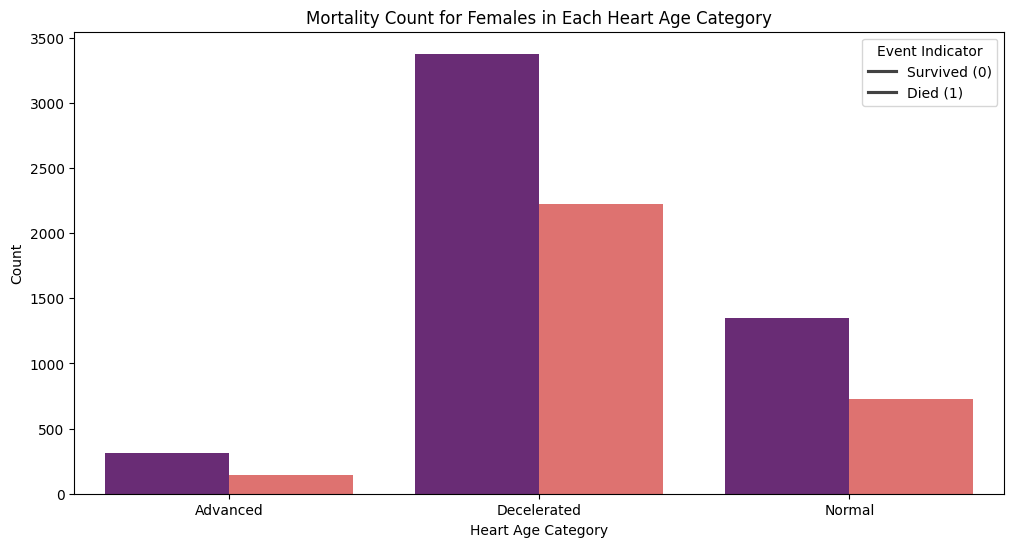

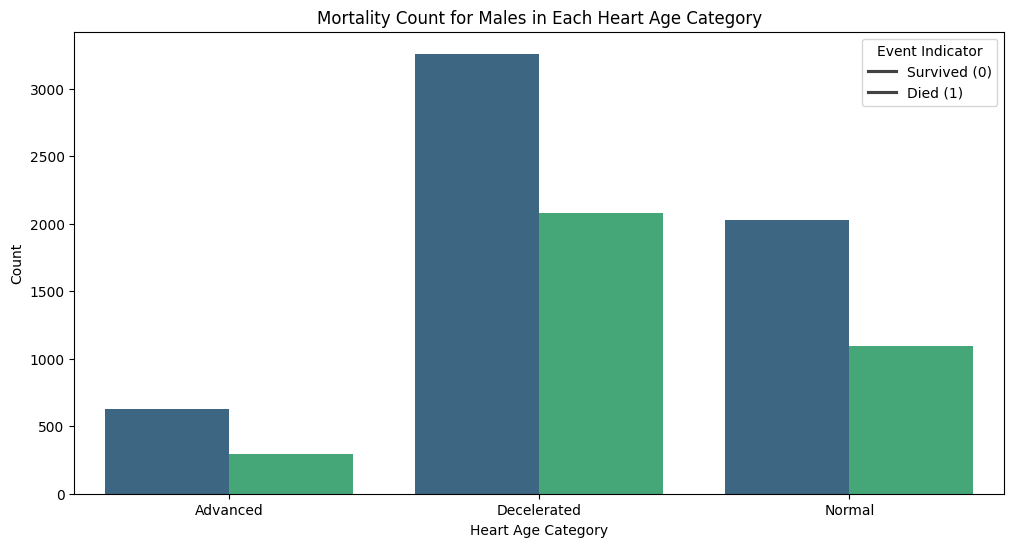

In [9]:
# Aggregate data for females: Count occurrences of each event_indicator within each heart_age_category
count_data_f = mortality_f.groupby(['heart_age_category', 'event_indicator']).size().reset_index(name='count')

# Plotting for females
plt.figure(figsize=(12, 6))
sns.barplot(data=count_data_f, x='heart_age_category', y='count', hue='event_indicator', palette='magma')
plt.title('Mortality Count for Females in Each Heart Age Category')
plt.xlabel('Heart Age Category')
plt.ylabel('Count')
plt.legend(title='Event Indicator', labels=['Survived (0)', 'Died (1)'])
plt.show()

# Aggregate data for males: Count occurrences of each event_indicator within each heart_age_category
count_data_m = mortality_m.groupby(['heart_age_category', 'event_indicator']).size().reset_index(name='count')

# Plotting for males
plt.figure(figsize=(12, 6))
sns.barplot(data=count_data_m, x='heart_age_category', y='count', hue='event_indicator', palette='viridis')
plt.title('Mortality Count for Males in Each Heart Age Category')
plt.xlabel('Heart Age Category')
plt.ylabel('Count')
plt.legend(title='Event Indicator', labels=['Survived (0)', 'Died (1)'])
plt.show()



Decelerated:
Restricted Mean Survival Time (up to 365 days): 253.83577293823646
Normal:
Restricted Mean Survival Time (up to 365 days): 267.9296724470135
Advanced:
Restricted Mean Survival Time (up to 365 days): 275.511982570806


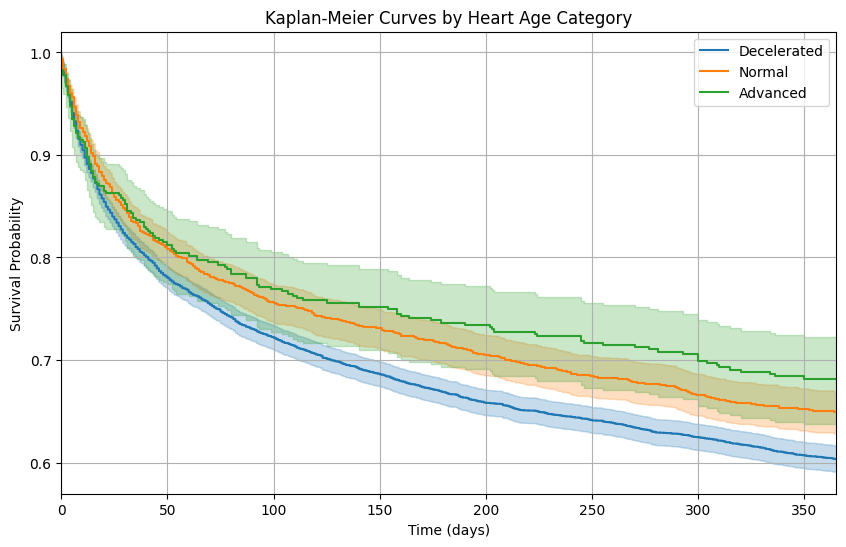

In [10]:

# Drop patients with missing heart age gap data

mortality_analysis = mortality_f.dropna(subset=['heart_age_gap'])

# Create Kaplan-Meier fitter objects for each age group
age_groups = mortality_analysis["heart_age_category"].unique()
kmf_results = {}

for age_group in age_groups:
    subset = mortality_analysis[mortality_analysis["heart_age_category"] == age_group]
    
    # Initialize KaplanMeierFitter
    kmf = KaplanMeierFitter()
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=subset["time_to_event"], event_observed=subset["event_indicator"], label=age_group)
    
    # Store the fitted model
    kmf_results[age_group] = kmf
    
    # Calculate restricted mean survival time up to a specific time point (e.g., 365 days)
    t_max = 365  # You can adjust this time point as needed
    restricted_mean = restricted_mean_survival_time(kmf, t=t_max)
    
    print(f"{age_group}:")
    print(f"Restricted Mean Survival Time (up to {t_max} days): {restricted_mean}")

# Plot the Kaplan-Meier curves
plt.figure(figsize=(10, 6))
for age_group, kmf in kmf_results.items():
    kmf.plot(label=age_group)

plt.xlim(0, 365)

plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Curves by Heart Age Category")
plt.grid(True)
plt.legend()
plt.show()

Decelerated:
Restricted Mean Survival Time (up to 365 days): 255.9960674157302
Normal:
Restricted Mean Survival Time (up to 365 days): 265.6732927220263
Advanced:
Restricted Mean Survival Time (up to 365 days): 276.54378378378385


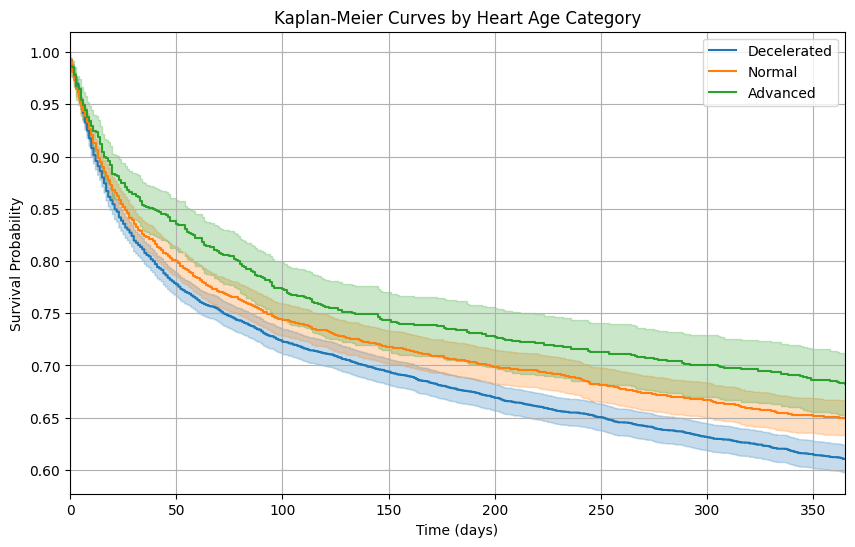

In [11]:
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time 
# Drop patients with missing heart age gap data

mortality_analysis = mortality_m.dropna(subset=['heart_age_gap'])

# Create Kaplan-Meier fitter objects for each age group
age_groups = mortality_analysis["heart_age_category"].unique()
kmf_results = {}

for age_group in age_groups:
    subset = mortality_analysis[mortality_analysis["heart_age_category"] == age_group]
    
    # Initialize KaplanMeierFitter
    kmf = KaplanMeierFitter()
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=subset["time_to_event"], event_observed=subset["event_indicator"], label=age_group)
    
    # Store the fitted model
    kmf_results[age_group] = kmf
    
    # Calculate restricted mean survival time up to a specific time point (e.g., 365 days)
    t_max = 365  # You can adjust this time point as needed
    restricted_mean = restricted_mean_survival_time(kmf, t=t_max)
    
    print(f"{age_group}:")
    print(f"Restricted Mean Survival Time (up to {t_max} days): {restricted_mean}")

# Plot the Kaplan-Meier curves
plt.figure(figsize=(10, 6))
for age_group, kmf in kmf_results.items():
    kmf.plot(label=age_group)

plt.xlim(0, 365)

plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Curves by Heart Age Category")
plt.grid(True)
plt.legend()
plt.show()

<lifelines.CoxPHFitter: fitted with 8137 total observations, 5038 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 8137
number of events observed = 3099
   partial log-likelihood = -27209.64
         time fit was run = 2024-09-23 17:14:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Advanced    -0.11      0.90      0.09           -0.29            0.07                0.75                1.07
Decelerated  0.16      1.17      0.04            0.07            0.24                1.08                1.27

             cmp to     z      p  -log2(p)
covariate                                 
Advanced       0.00 -1.19   0.24      2.08
Decelerated    0.00  3.71 <0.005     12.24
---
Concordance = 0.52
Partial AIC = 54423.29
log-likelihood ratio test = 21.64 on 2 df
-log2(p) of ll-ratio test = 15.61

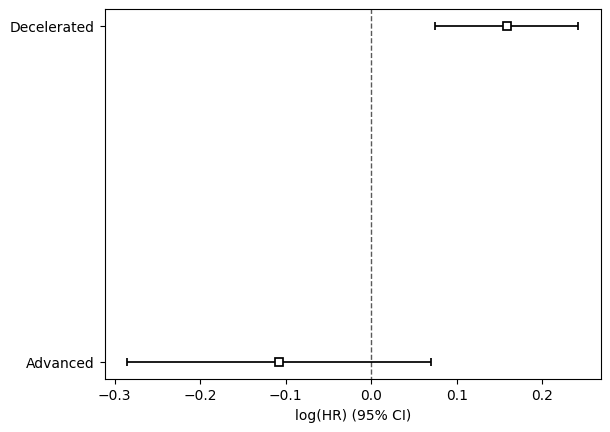

In [12]:
# Cox proportional hazards analysis

# The dataset should include time_to_event, event_indicator, and other covariates like heart_age_category
cph = CoxPHFitter()

# Fit the Cox model using relevant columns
cph.fit(mortality_f, duration_col="time_to_event", event_col="event_indicator", formula = 'Advanced + Decelerated')

# Print the summary to see hazard ratios and p-values
cph.print_summary()

# Plot the survival function based on the Cox model
cph.plot()
plt.show()



<lifelines.CoxPHFitter: fitted with 9384 total observations, 5918 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 9384
number of events observed = 3466
   partial log-likelihood = -30952.96
         time fit was run = 2024-09-23 17:14:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Advanced    -0.13      0.88      0.07           -0.25            0.00                0.78                1.00
Decelerated  0.13      1.14      0.04            0.06            0.20                1.06                1.22

             cmp to     z      p  -log2(p)
covariate                                 
Advanced       0.00 -1.91   0.06      4.15
Decelerated    0.00  3.45 <0.005     10.79
---
Concordance = 0.52
Partial AIC = 61909.91
log-likelihood ratio test = 24.38 on 2 df
-log2(p) of ll-ratio test = 17.59

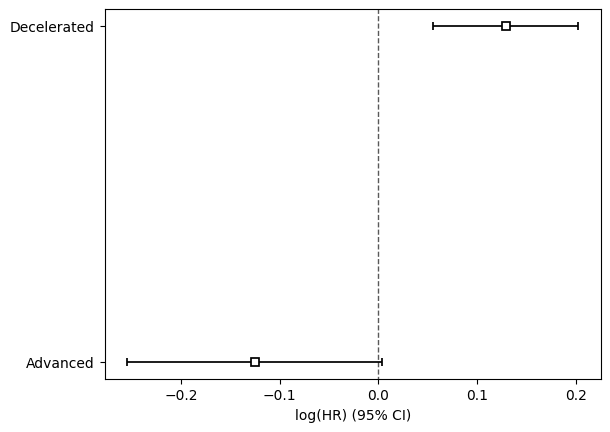

In [13]:
# Cox proportional hazards analysis

# The dataset should include time_to_event, event_indicator, and other covariates like heart_age_category
cph = CoxPHFitter()

# Fit the Cox model using relevant columns
cph.fit(mortality_m, duration_col="time_to_event", event_col="event_indicator", formula = 'Advanced + Decelerated')

# Print the summary to see hazard ratios and p-values
cph.print_summary()

# Plot the survival function based on the Cox model
cph.plot()
plt.show()

In [14]:
# For the gender stratified analysis we can conclude that the advanced heart age has no statistical 
# significance in the mortality of the patients, in contrast to the decelerated heart age which has 
# a surprising statistical significance in the mortality of the patients, being directly
# proportional with mortality, even when stratified. 


## Hospitalization analysis


In [15]:
hosp_f.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,race,gender,anchor_year_group,anchor_year,anchor_age,dod,study_id,file_name,ecg_time,path,length_of_stay_(days),subject_id_y,icd_code,icd_version,seq_num,long_title,age,predicted_age,heart_age_gap,time_to_event,event_indicator,hospitalization_count,Advanced,Decelerated,heart_age_category_Decelerated,heart_age_category_Normal
0,0,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,EW EMER.,EMERGENCY ROOM,BLACK/AFRICAN AMERICAN,F,2008 - 2010,2186,73,2193-08-26,49560547.0,49560547.0,2188-01-04 16:43:00,files/p1000/p10000980/s49560547/49560547,1,10000980.0,4280,9.0,10.0,"Congestive heart failure, unspecified",75,50.321297,-24.678703,2061.0,0,14,0,1,True,False
3,3,10002013,21975601,2159-12-14 23:55:00,2159-12-17 14:04:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2008 - 2010,2156,53,NaN,48919255.0,48919255.0,2159-12-17 03:19:00,files/p1000/p10002013/s48919255/48919255,2,10002013.0,42832,9.0,2.0,Chronic diastolic heart failure,56,43.551422,-12.448578,400.0,0,18,0,1,True,False
4,4,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,EW EMER.,PROCEDURE SITE,WHITE,F,2008 - 2010,2128,80,2131-03-10,48586557.0,48586557.0,2129-08-11 08:43:00,files/p1000/p10002155/s48586557/48586557,14,10002155.0,42821,9.0,3.0,Acute systolic heart failure,81,64.386223,-16.613777,582.0,0,9,0,1,True,False
5,5,10002428,23473524,2156-05-11 14:49:00,2156-05-22 14:16:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2011 - 2013,2155,80,NaN,47306943.0,47306943.0,2156-05-16 23:28:00,files/p1000/p10002428/s47306943/47306943,10,10002428.0,42843,9.0,3.0,Acute on chronic combined systolic and diastol...,81,66.671562,-14.328438,400.0,0,10,0,1,True,False
8,8,10003502,20459702,2166-02-15 13:06:00,2166-02-19 16:02:00,EW EMER.,EMERGENCY ROOM,WHITE - RUSSIAN,F,2008 - 2010,2161,86,2169-09-10,47430834.0,47430834.0,2166-02-18 11:17:00,files/p1000/p10003502/s47430834/47430834,4,10003502.0,42833,9.0,2.0,Acute on chronic diastolic heart failure,91,73.978958,-17.021042,1302.0,0,11,0,1,True,False


In [16]:
# Create a new function to categorize the heart age gap

def categorize_heart_age_gap(row):
    '''
    This function categorizes the heart age gap into three categories:
    
    input: row from a DataFrame
    output: heart age category based on the heart age gap
    '''
    if row['heart_age_gap'] > 8.38:
        return 'Advanced'
    elif row['heart_age_gap'] < -8.38:
        return 'Decelerated'
    else:
        return 'Normal'

# Apply the function to the DataFrame
hosp_f['heart_age_category'] = hosp_f.\
    apply(categorize_heart_age_gap, axis=1)

#Lets calculate the time to event for the patients that died

hosp_f['dod'] = hosp_f['dod'].astype('datetime64[ns]')
hosp_f['admittime'] = hosp_f['admittime']\
    .astype('datetime64[ns]')

hosp_f['time_to_event'] = (hosp_f['dod'] - \
    hosp_f['admittime']).dt.days

# Lets censor the patients that are still alive or that died after 365 days of their last 
# hospitalization

hosp_f['event_indicator'] = np.where(
    hosp_f['dod'].isna() | (hosp_f['time_to_event'] > 365), 
    0,  # Still alive or died after 365 days (censored)
    1   # Died within 365 days
)

# Replace all the NaN values in the 'time_to_event' column with 365
hosp_f['time_to_event'] = hosp_f['time_to_event'].fillna(400)

# Create a new column to categorize the heart age gap for males
def categorize_heart_age_gap(row):
    if row['heart_age_gap'] > 8.38:
        return 'Advanced'
    elif row['heart_age_gap'] < -8.38:
        return 'Decelerated'
    else:
        return 'Normal'

# Apply the categorization function to hosp_m
hosp_m['heart_age_category'] = hosp_m.apply(categorize_heart_age_gap, axis=1)

# Calculate time to event for males
hosp_m['dod'] = hosp_m['dod'].astype('datetime64[ns]')
hosp_m['admittime'] = hosp_m['admittime'].astype('datetime64[ns]')
hosp_m['time_to_event'] = (hosp_m['dod'] - hosp_m['admittime']).dt.days

# Censor patients who are still alive or died after 365 days
hosp_m['event_indicator'] = np.where(
    hosp_m['dod'].isna() | (hosp_m['time_to_event'] > 365), 
    0,  # Still alive or died after 365 days (censored)
    1   # Died within 365 days
)

# Replace NaN values in the 'time_to_event' column with 400 days (censored)
hosp_m['time_to_event'] = hosp_m['time_to_event'].fillna(400)

hosp_m.head()
hosp_f.head()

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2433882565.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_f['heart_age_category'] = hosp_f.\
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2433882565.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_f['dod'] = hosp_f['dod'].astype('datetime64[ns]')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2433882565.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,race,gender,anchor_year_group,anchor_year,anchor_age,dod,study_id,file_name,ecg_time,path,length_of_stay_(days),subject_id_y,icd_code,icd_version,seq_num,long_title,age,predicted_age,heart_age_gap,time_to_event,event_indicator,hospitalization_count,Advanced,Decelerated,heart_age_category_Decelerated,heart_age_category_Normal,heart_age_category
0,0,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,EW EMER.,EMERGENCY ROOM,BLACK/AFRICAN AMERICAN,F,2008 - 2010,2186,73,2193-08-26,49560547.0,49560547.0,2188-01-04 16:43:00,files/p1000/p10000980/s49560547/49560547,1,10000980.0,4280,9.0,10.0,"Congestive heart failure, unspecified",75,50.321297,-24.678703,2061.0,0,14,0,1,True,False,Decelerated
3,3,10002013,21975601,2159-12-14 23:55:00,2159-12-17 14:04:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2008 - 2010,2156,53,NaT,48919255.0,48919255.0,2159-12-17 03:19:00,files/p1000/p10002013/s48919255/48919255,2,10002013.0,42832,9.0,2.0,Chronic diastolic heart failure,56,43.551422,-12.448578,400.0,0,18,0,1,True,False,Decelerated
4,4,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,EW EMER.,PROCEDURE SITE,WHITE,F,2008 - 2010,2128,80,2131-03-10,48586557.0,48586557.0,2129-08-11 08:43:00,files/p1000/p10002155/s48586557/48586557,14,10002155.0,42821,9.0,3.0,Acute systolic heart failure,81,64.386223,-16.613777,582.0,0,9,0,1,True,False,Decelerated
5,5,10002428,23473524,2156-05-11 14:49:00,2156-05-22 14:16:00,EW EMER.,EMERGENCY ROOM,WHITE,F,2011 - 2013,2155,80,NaT,47306943.0,47306943.0,2156-05-16 23:28:00,files/p1000/p10002428/s47306943/47306943,10,10002428.0,42843,9.0,3.0,Acute on chronic combined systolic and diastol...,81,66.671562,-14.328438,400.0,0,10,0,1,True,False,Decelerated
8,8,10003502,20459702,2166-02-15 13:06:00,2166-02-19 16:02:00,EW EMER.,EMERGENCY ROOM,WHITE - RUSSIAN,F,2008 - 2010,2161,86,2169-09-10,47430834.0,47430834.0,2166-02-18 11:17:00,files/p1000/p10003502/s47430834/47430834,4,10003502.0,42833,9.0,2.0,Acute on chronic diastolic heart failure,91,73.978958,-17.021042,1302.0,0,11,0,1,True,False,Decelerated


                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                 5848
Model:                               GLM   Df Residuals:                     5845
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -19419.
Date:                   Mon, 23 Sep 2024   Deviance:                       4625.0
Time:                           12:14:45   Pearson chi2:                 6.91e+03
No. Iterations:                        5   Pseudo R-squ. (CS):           0.006101
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.35

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\725443618.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


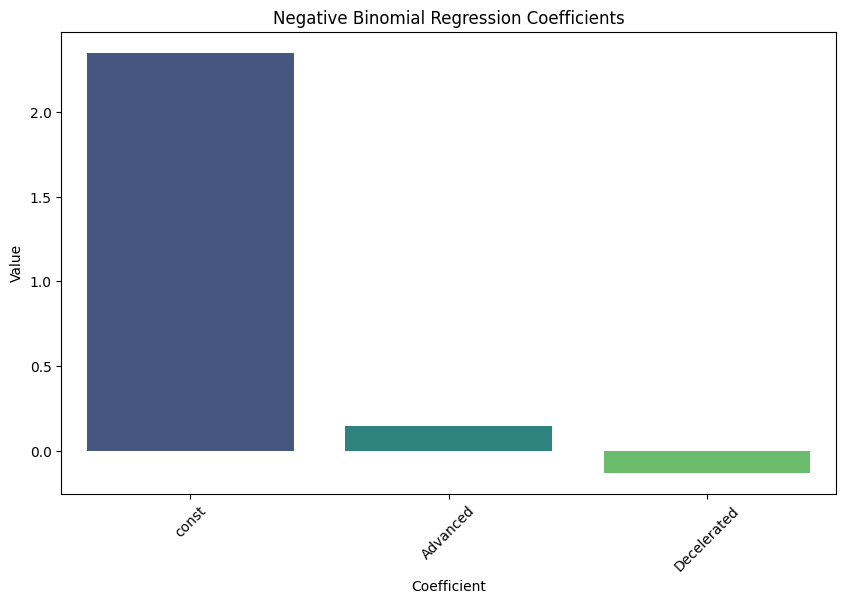

In [17]:
# Lets perform a negative binomial regression to see the correlation between the heart age gap 
# and the outcome (Number of hospitalizations in the next 365 days)
'''
Because the data has 3 categories, we will use dummy variables to represent the heart age categories.

'''

# Perform the negative binomial regression
X = hosp_f[[ 'Advanced', 'Decelerated']]
y = hosp_f['hospitalization_count']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Display the model summary
print(model.summary())

# Lets visualize the results

# plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')
plt.title('Negative Binomial Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()



                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                 6905
Model:                               GLM   Df Residuals:                     6902
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -22830.
Date:                   Mon, 23 Sep 2024   Deviance:                       5261.1
Time:                           12:14:45   Pearson chi2:                 7.46e+03
No. Iterations:                        5   Pseudo R-squ. (CS):           0.009922
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.31

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2407138212.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


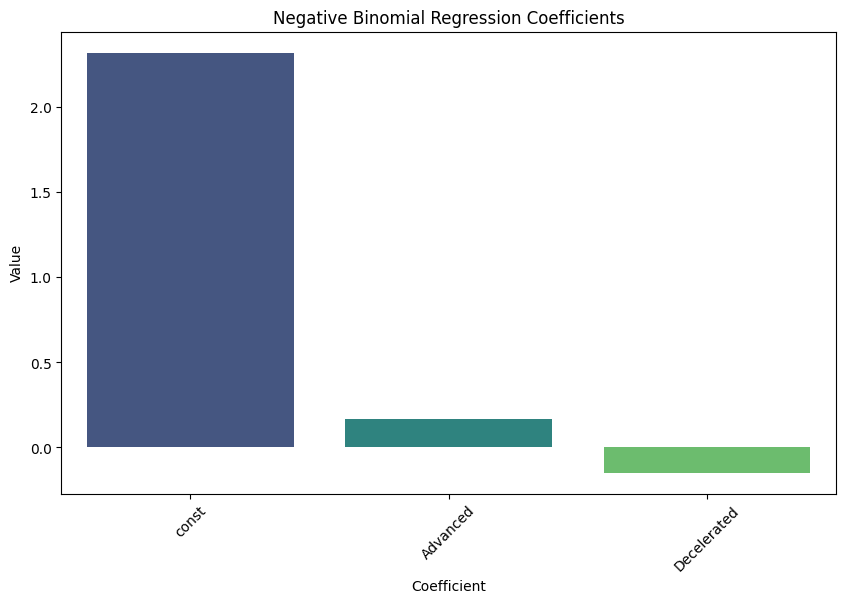

In [18]:
# Lets perform a negative binomial regression to see the correlation between the heart age gap 
# and the outcome (Number of hospitalizations in the next 365 days)
'''
Because the data has 3 categories, we will use dummy variables to represent the heart age categories.

'''

# Perform the negative binomial regression
X = hosp_m[[ 'Advanced', 'Decelerated']]
y = hosp_m['hospitalization_count']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Display the model summary
print(model.summary())

# Lets visualize the results

# plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')
plt.title('Negative Binomial Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()



In [19]:
# The stratified analysis for the hospitalization data shows that the advanced heart age maintains
# a statistical significance in the number of hospitalizations even when stratified by gender, 
# in the same direction. Both for females and for males, the advanced heart age is directly 
# proportional to the number of hospitalizations a patient will have in the next 365 days. And a 
# decelerated heart age is inversely proportional to the number of hospitalizations a patient will
# have in the next 365 days. 

# Now, lets stratify the data by comorbidities 

Lets begin with the extraction of the data

In [20]:
#First, lets import the comorbidities data, stored in the admissions.csv file

admissions = pd.read_csv(r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions_icd.csv')

admissions = admissions.dropna(subset=['icd_code'])

In [21]:
# Filter the data to include any of the diagnoses of interest

diabetes_codes = ['E10', 'E11', '250']
hypertension_codes = ['401', '402', '403', '404', '405', 'I10']
infarction_codes = ['412', 'I25']

# Filter the data to include any of the diagnoses of interest in the mortality 

admissions_diabetes = admissions[admissions['icd_code'].str.startswith(tuple(diabetes_codes))]
admissions_hypertension = admissions[admissions['icd_code'].str.startswith(tuple(hypertension_codes))]
admissions_infarction = admissions[admissions['icd_code'].str.startswith(tuple(infarction_codes))]

In [22]:
# Merge the comorbidity data with the mortality data, only keeping the patients that are in the 
#mortaility data

#change the name of the subject_id column to match the mortality data

admissions_diabetes = admissions_diabetes.rename(columns={'subject_id_x': 'subject_id'})
admissions_hypertension = admissions_hypertension.rename(columns={'subject_id_x': 'subject_id'})
admissions_infarction = admissions_infarction.rename(columns={'subject_id_x': 'subject_id'})
mortality = mortality.rename(columns={'subject_id_x': 'subject_id'})

# Merge the comorbidity data with the mortality data
mortality_diabetes = pd.merge(mortality, admissions_diabetes, on='subject_id', how='inner')
mortality_hypertension = pd.merge(mortality, admissions_hypertension, on='subject_id', how='inner')
mortality_infarction = pd.merge(mortality, admissions_infarction, on='subject_id', how='inner')

# Same with hospitalization

hosp_diabetes = pd.merge(hospitalization, admissions_diabetes, on='subject_id', how='inner')
hosp_hypertension = pd.merge(hospitalization, admissions_hypertension, on='subject_id', how='inner')
hosp_infarction = pd.merge(hospitalization, admissions_infarction, on='subject_id', how='inner')

Now, continue with the MORTALITY ANALYSIS 

In [23]:
# Lets perform a chi-squared test to see if the comorbidities are associated with the mortality of the

correlation = mortality_diabetes[['heart_age_gap', 'event_indicator']].corr(method='spearman')
print( f'The Spearman correlation coefficient between the heart age gap and the event indicator \
is: {correlation["event_indicator"]["heart_age_gap"]}')

correlation = mortality_hypertension[['heart_age_gap', 'event_indicator']].corr(method='spearman')
print( f'The Spearman correlation coefficient between the heart age gap and the event indicator \
is: {correlation["event_indicator"]["heart_age_gap"]}')

correlation = mortality_infarction [['heart_age_gap', 'event_indicator']].corr(method='spearman')
print( f'The Spearman correlation coefficient between the heart age gap and the event indicator \
is: {correlation["event_indicator"]["heart_age_gap"]}')

The Spearman correlation coefficient between the heart age gap and the event indicator is: 0.07765333305950069
The Spearman correlation coefficient between the heart age gap and the event indicator is: -0.019050601702932046
The Spearman correlation coefficient between the heart age gap and the event indicator is: 0.008979165116787636


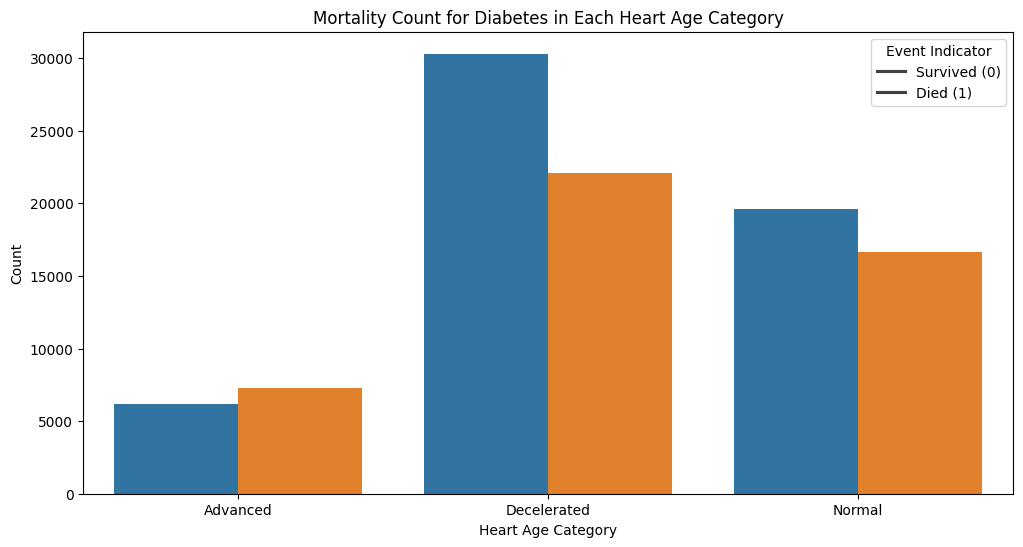

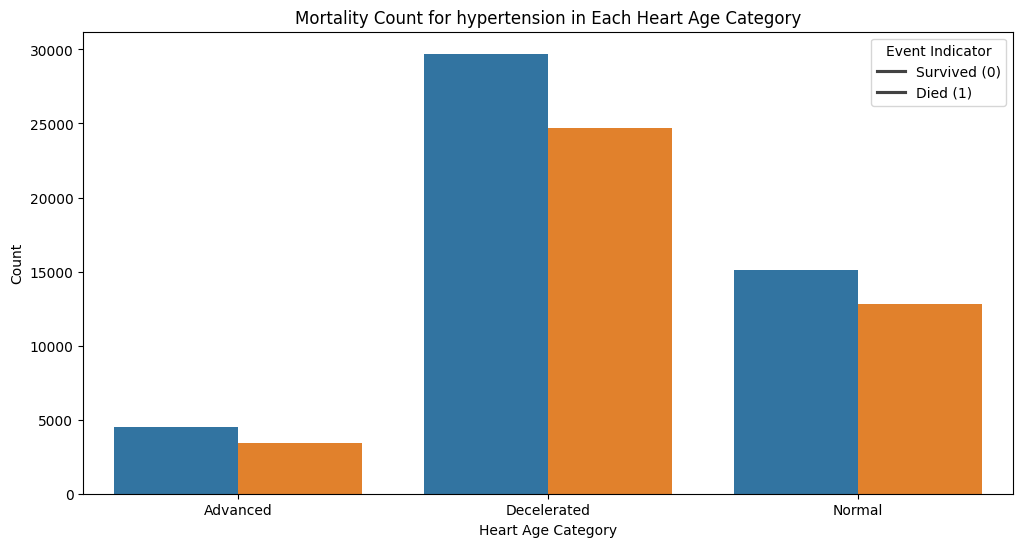

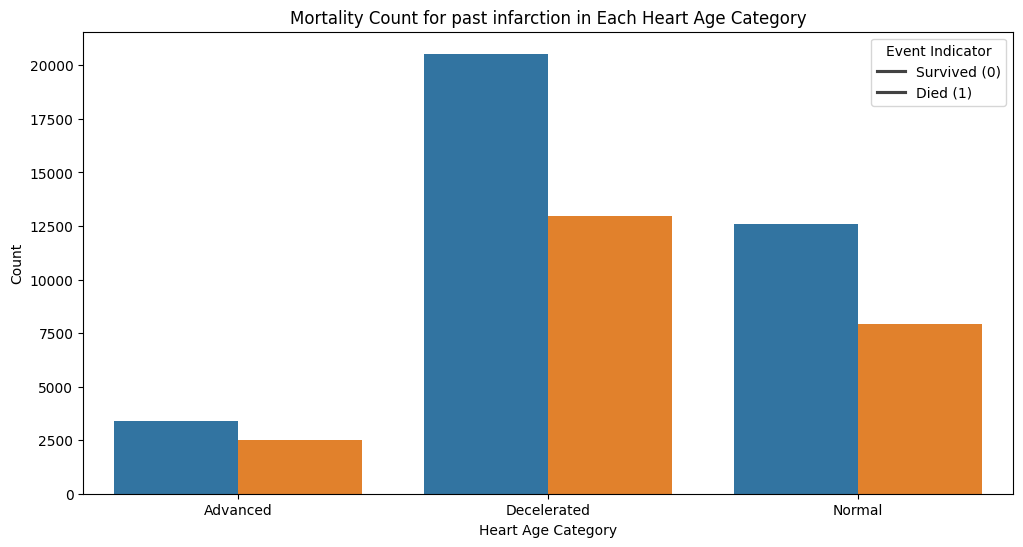

In [24]:
# Plot the mortality data for the comorbidities

#Diabetes 
count_data_diabetes = mortality_diabetes.groupby(['heart_age_category', 'event_indicator'])\
    .size().reset_index(name='count')

count_data_hypertension = mortality_hypertension.groupby(['heart_age_category', 'event_indicator'])\
    .size().reset_index(name='count')

count_data_infarction = mortality_infarction.groupby(['heart_age_category', 'event_indicator'])\
    .size().reset_index(name='count')

# Plotting for diabetes
plt.figure(figsize=(12, 6))
sns.barplot(data=count_data_diabetes, x='heart_age_category', y='count', hue='event_indicator')
plt.title('Mortality Count for Diabetes in Each Heart Age Category')
plt.xlabel('Heart Age Category')
plt.ylabel('Count')
plt.legend(title='Event Indicator', labels=['Survived (0)', 'Died (1)'])
plt.show()

# Hypertension
plt.figure(figsize=(12, 6))
sns.barplot(data=count_data_hypertension, x='heart_age_category', y='count', hue='event_indicator')
plt.title('Mortality Count for hypertension in Each Heart Age Category')
plt.xlabel('Heart Age Category')
plt.ylabel('Count')
plt.legend(title='Event Indicator', labels=['Survived (0)', 'Died (1)'])
plt.show()

# Infarction
plt.figure(figsize=(12, 6))
sns.barplot(data=count_data_infarction, x='heart_age_category', y='count', hue='event_indicator')
plt.title('Mortality Count for past infarction in Each Heart Age Category')
plt.xlabel('Heart Age Category')
plt.ylabel('Count')
plt.legend(title='Event Indicator', labels=['Survived (0)', 'Died (1)'])
plt.show()


Diabetes - Decelerated:
Restricted Mean Survival Time (up to 365 days): 246.6702448714522
Diabetes - Normal:
Restricted Mean Survival Time (up to 365 days): 235.91205849889627
Diabetes - Advanced:
Restricted Mean Survival Time (up to 365 days): 213.58116471553203


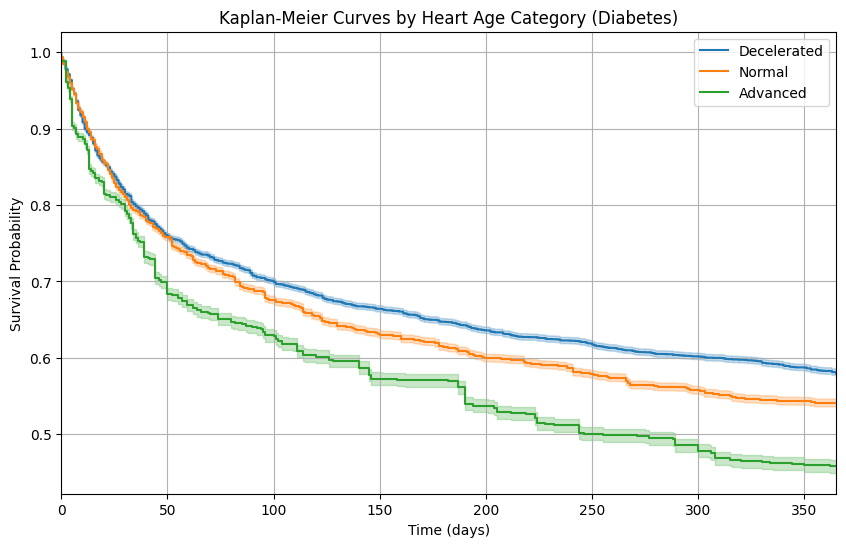

Hypertension - Decelerated:
Restricted Mean Survival Time (up to 365 days): 236.29207429201927
Hypertension - Normal:
Restricted Mean Survival Time (up to 365 days): 233.4132290695172
Hypertension - Advanced:
Restricted Mean Survival Time (up to 365 days): 243.52887995981928


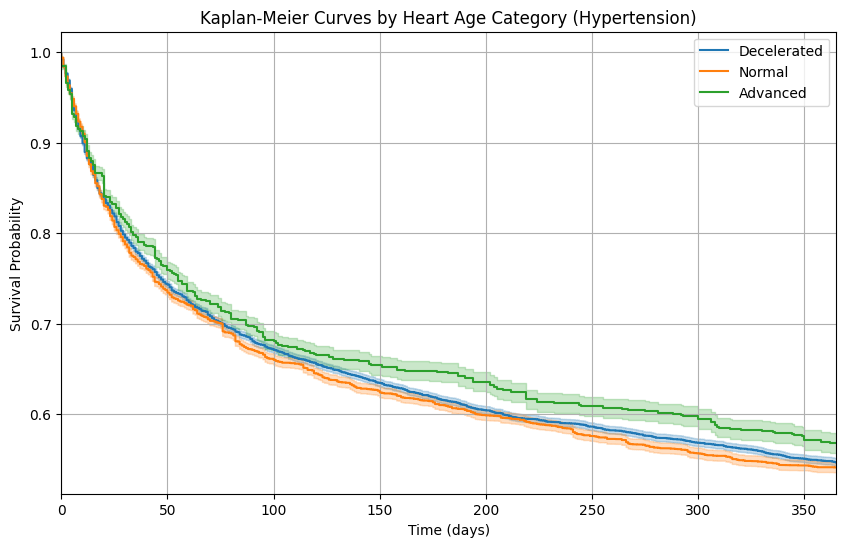

Infarction - Decelerated:
Restricted Mean Survival Time (up to 365 days): 256.5228697677194
Infarction - Normal:
Restricted Mean Survival Time (up to 365 days): 250.31297189341927
Infarction - Advanced:
Restricted Mean Survival Time (up to 365 days): 246.75254065040647


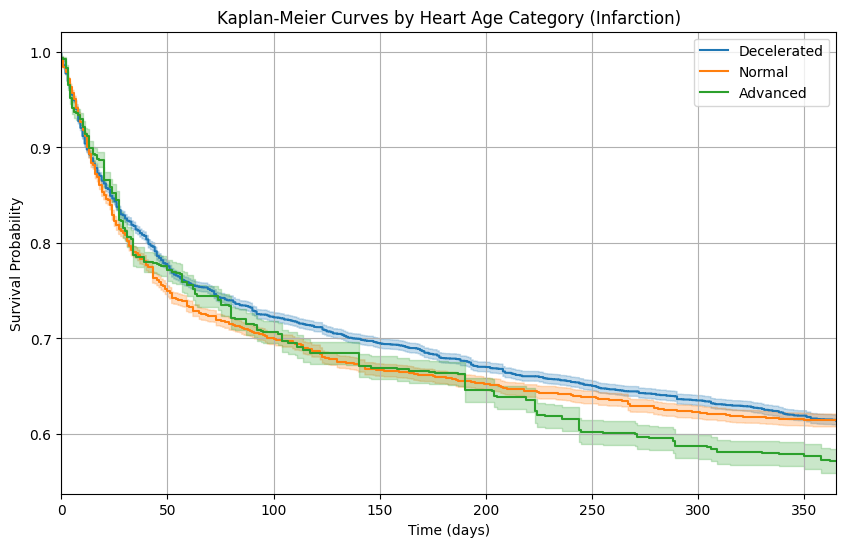

In [25]:
# Function to perform Kaplan-Meier analysis and plot for each dataset
def kaplan_meier_analysis(mortality_data, condition_name):
    # Drop patients with missing heart age gap data
    mortality_analysis = mortality_data.dropna(subset=['heart_age_gap'])
    
    # Create Kaplan-Meier fitter objects for each heart age category
    age_groups = mortality_analysis["heart_age_category"].unique()
    kmf_results = {}

    for age_group in age_groups:
        subset = mortality_analysis[mortality_analysis["heart_age_category"] == age_group]

        # Initialize KaplanMeierFitter
        kmf = KaplanMeierFitter()

        # Fit the Kaplan-Meier model
        kmf.fit(durations=subset["time_to_event"], event_observed=subset["event_indicator"], label=f"{condition_name} - {age_group}")

        # Store the fitted model
        kmf_results[age_group] = kmf

        # Calculate restricted mean survival time up to a specific time point (e.g., 365 days)
        t_max = 365  # You can adjust this time point as needed
        restricted_mean = restricted_mean_survival_time(kmf, t=t_max)

        print(f"{condition_name} - {age_group}:")
        print(f"Restricted Mean Survival Time (up to {t_max} days): {restricted_mean}")

    # Plot the Kaplan-Meier curves for this condition
    plt.figure(figsize=(10, 6))
    for age_group, kmf in kmf_results.items():
        kmf.plot(label=age_group)

    plt.xlim(0, 365)
    plt.xlabel("Time (days)")
    plt.ylabel("Survival Probability")
    plt.title(f"Kaplan-Meier Curves by Heart Age Category ({condition_name})")
    plt.grid(True)
    plt.legend()
    plt.show()

# Analyze and plot for mortality_diabetes
kaplan_meier_analysis(mortality_diabetes, "Diabetes")

# Analyze and plot for mortality_hypertension
kaplan_meier_analysis(mortality_hypertension, "Hypertension")

# Analyze and plot for mortality_infarction
kaplan_meier_analysis(mortality_infarction, "Infarction")

Cox Proportional Hazards Summary for Diabetes


<lifelines.CoxPHFitter: fitted with 102005 total observations, 56049 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 102005
number of events observed = 45956
   partial log-likelihood = -517306.10
         time fit was run = 2024-09-23 17:15:07 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Advanced     0.23      1.26      0.01            0.20            0.26                1.23                1.30
Decelerated -0.11      0.90      0.01           -0.13           -0.09                0.88                0.92

             cmp to      z      p  -log2(p)
covariate                                  
Advanced       0.00  16.45 <0.005    199.53
Decelerated    0.00 -10.42 <0.005     81.99
---
Concordance = 0.53
Partial AIC = 1034616.20
log-likelihood ratio test = 600.79 on 2 df
-log2(p) of ll-ratio test = 433.38

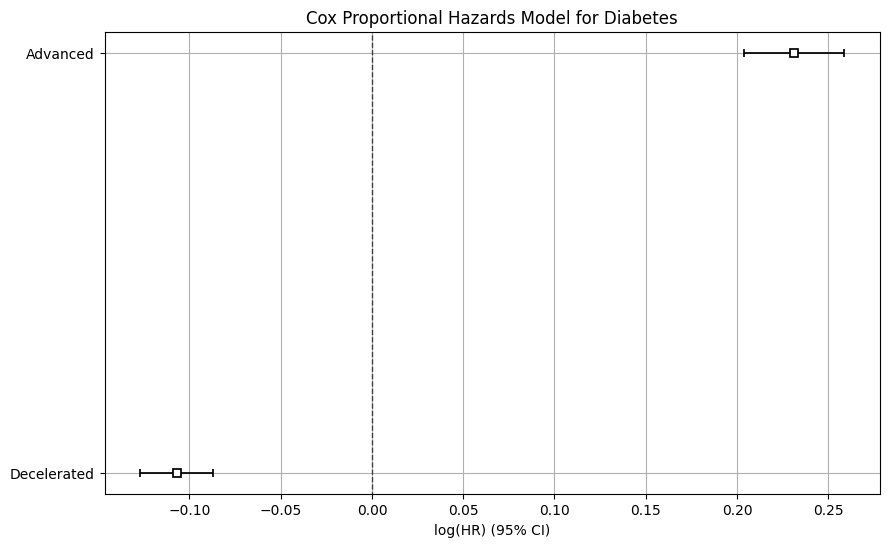

Cox Proportional Hazards Summary for Hypertension


<lifelines.CoxPHFitter: fitted with 90222 total observations, 49323 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 90222
number of events observed = 40899
   partial log-likelihood = -455535.43
         time fit was run = 2024-09-23 17:15:08 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Advanced    -0.08      0.92      0.02           -0.12           -0.05                0.88                0.95
Decelerated -0.02      0.98      0.01           -0.04            0.00                0.96                1.00

             cmp to     z      p  -log2(p)
covariate                                 
Advanced       0.00 -4.42 <0.005     16.65
Decelerated    0.00 -1.65   0.10      3.34
---
Concordance = 0.50
Partial AIC = 911074.85
log-likelihood ratio test = 19.89 on 2 df
-log2(p) of ll-ratio test = 14.35

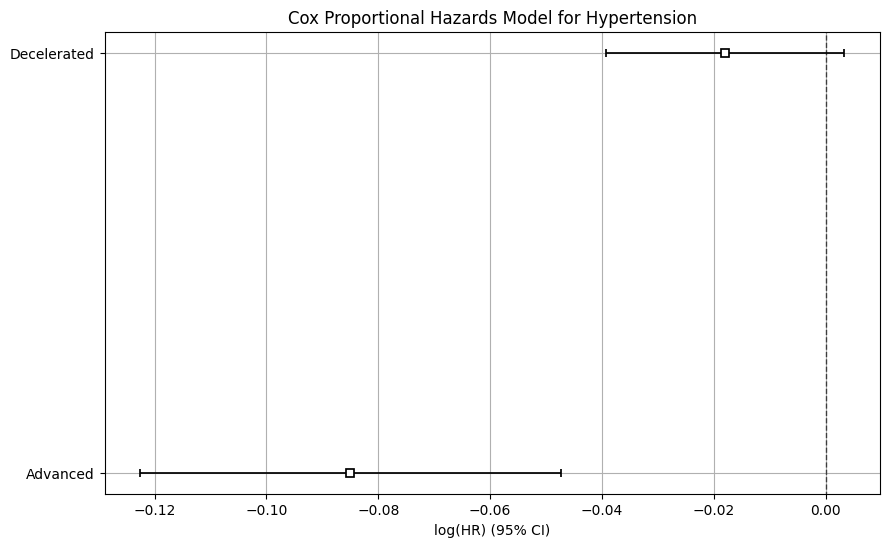

Cox Proportional Hazards Summary for Infarction


<lifelines.CoxPHFitter: fitted with 59927 total observations, 36530 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 59927
number of events observed = 23397
   partial log-likelihood = -252059.13
         time fit was run = 2024-09-23 17:15:08 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Advanced     0.10      1.11      0.02            0.06            0.15                1.06                1.16
Decelerated -0.02      0.98      0.01           -0.04            0.01                0.96                1.01

             cmp to     z      p  -log2(p)
covariate                                 
Advanced       0.00  4.39 <0.005     16.46
Decelerated    0.00 -1.09   0.27      1.87
---
Concordance = 0.51
Partial AIC = 504122.26
log-likelihood ratio test = 27.74 on 2 df
-log2(p) of ll-ratio test = 20.01

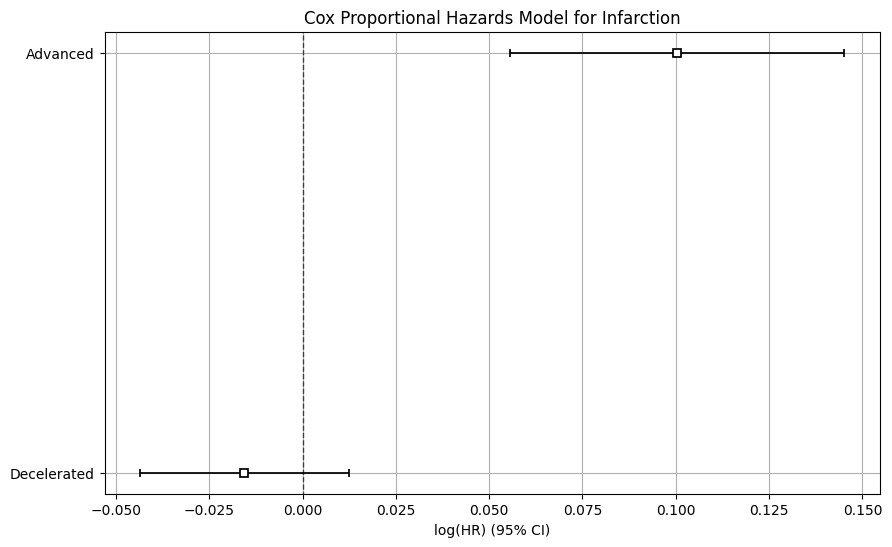

In [26]:
# Function to perform Cox proportional hazards analysis and plot for each dataset
def cox_proportional_hazards_analysis(mortality_data, condition_name):
    # The dataset should include 'time_to_event', 'event_indicator', and covariates like 'Advanced', 'Decelerated', or others
    cph = CoxPHFitter()
    
    # Fit the Cox model using relevant columns
    cph.fit(mortality_data, duration_col="time_to_event", event_col="event_indicator", formula='Advanced + Decelerated')

    # Print the summary to see hazard ratios and p-values
    print(f"Cox Proportional Hazards Summary for {condition_name}")
    cph.print_summary()

    # Plot the survival function based on the Cox model
    plt.figure(figsize=(10, 6))
    cph.plot()
    plt.title(f"Cox Proportional Hazards Model for {condition_name}")
    plt.grid(True)
    plt.show()

# Analyze and plot for mortality_diabetes
cox_proportional_hazards_analysis(mortality_diabetes, "Diabetes")

# Analyze and plot for mortality_hypertension
cox_proportional_hazards_analysis(mortality_hypertension, "Hypertension")

# Analyze and plot for mortality_infarction
cox_proportional_hazards_analysis(mortality_infarction, "Infarction")


# Now for the hospitalization analysis 

Negative Binomial Regression Summary for Diabetes
                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                83122
Model:                               GLM   Df Residuals:                    83119
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:            -3.5559e+05
Date:                   Mon, 23 Sep 2024   Deviance:                       53989.
Time:                           12:15:09   Pearson chi2:                 5.78e+04
No. Iterations:                        5   Pseudo R-squ. (CS):            0.02833
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2527431626.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


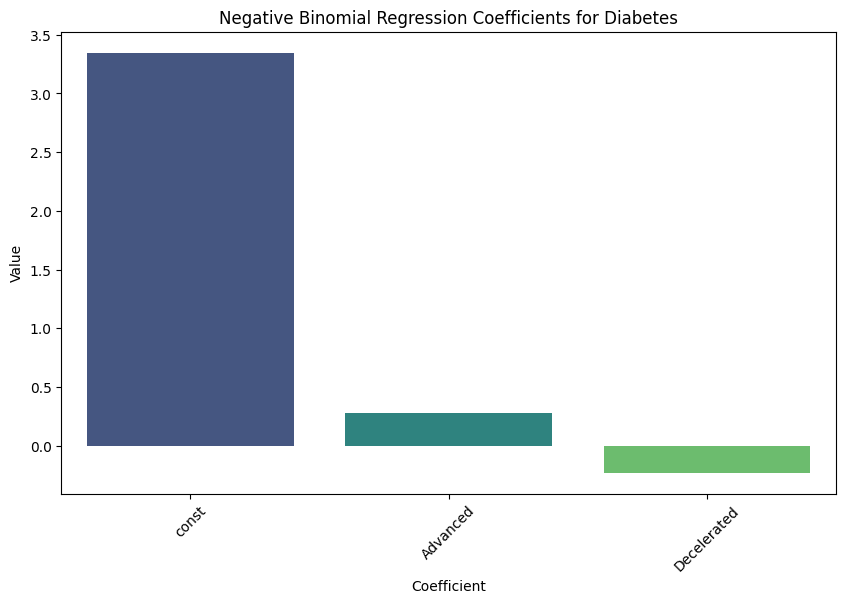

Negative Binomial Regression Summary for Hypertension
                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                71424
Model:                               GLM   Df Residuals:                    71421
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:            -2.9479e+05
Date:                   Mon, 23 Sep 2024   Deviance:                       50306.
Time:                           12:15:09   Pearson chi2:                 6.55e+04
No. Iterations:                        6   Pseudo R-squ. (CS):            0.04120
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2527431626.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


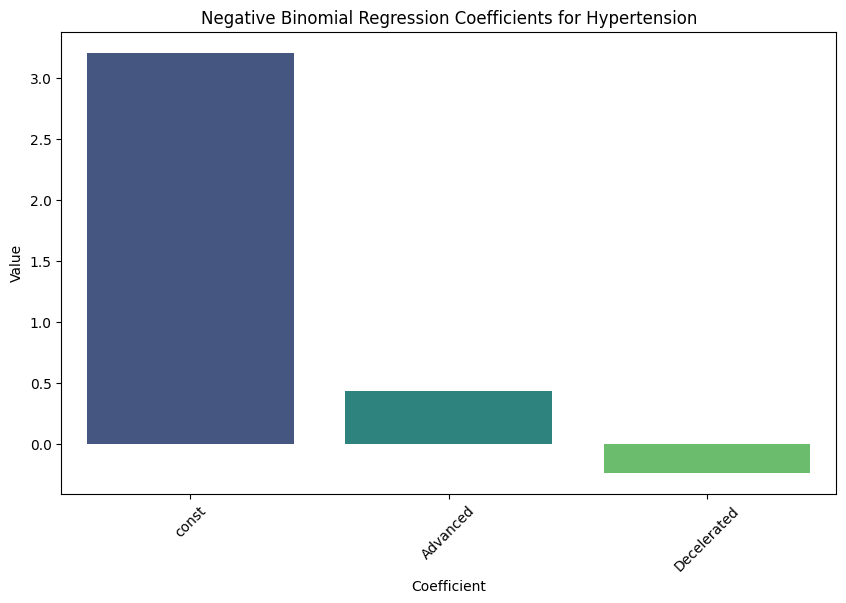

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Negative Binomial Regression Summary for Infarction
                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                49042
Model:                               GLM   Df Residuals:                    49039
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:            -2.0163e+05
Date:                   Mon, 23 Sep 2024   Deviance:                       31955.
Time:                           12:15:09   Pearson chi2:                 3.70e+04
No. Iterations:                        5   Pseudo R-squ. (CS):            0.02259
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_34036\2527431626.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


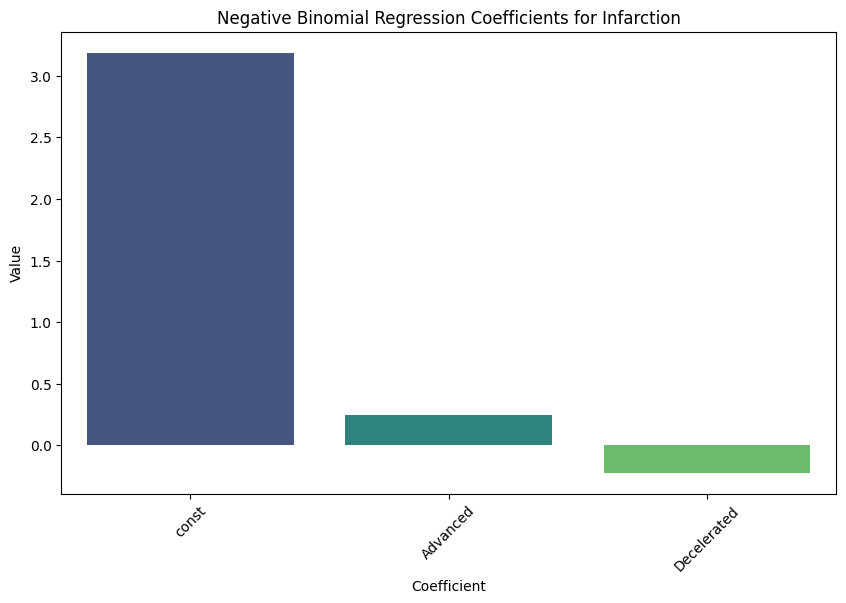

In [27]:
# Function to perform negative binomial regression and visualize results for each dataset
def negative_binomial_regression(hosp_data, condition_name):
    # Prepare the independent and dependent variables
    X = hosp_data[['Advanced', 'Decelerated']]
    y = hosp_data['hospitalization_count']

    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the negative binomial regression model
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

    # Display the model summary
    print(f"Negative Binomial Regression Summary for {condition_name}")
    print(model.summary())

    # Visualize the coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')
    plt.title(f'Negative Binomial Regression Coefficients for {condition_name}')
    plt.xlabel('Coefficient')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

# Analyze and visualize for hosp_diabetes
negative_binomial_regression(hosp_diabetes, "Diabetes")

# Analyze and visualize for hosp_hypertension
negative_binomial_regression(hosp_hypertension, "Hypertension")

# Analyze and visualize for hosp_infarction
negative_binomial_regression(hosp_infarction, "Infarction")
